In [140]:
import pandas as pd
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import matplotlib.pyplot as plt
import seaborn as sns
import utilities 

from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import R2Score,PearsonCorrCoef

ImportError: cannot import name 'LogisticRegression' from 'sklearn' (/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/__init__.py)

In [13]:
df = pd.read_csv("data/connectome_data.csv")
df.rename(columns={ df.columns[0]: "Subject" }, inplace = True)
df.to_pickle("data/connectome.pkl")

In [128]:
df = pd.read_pickle("data/connectome.pkl")

label = pd.read_csv("data/cognition_scores.csv")
label.rename(columns={ label.columns[0]: "Subject" }, inplace = True)

demographics = pd.read_csv("data/demographic.csv")

df = df.merge(demographics[["Gender","Subject"]], how='left', on='Subject')

In [94]:
class Net(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        
        super(Net, self).__init__()
        
        self.negative_slope = 0.05
        self.kernel_size = 2
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size//self.kernel_size, hidden_size//(self.kernel_size)))        
        self.layers.append(nn.Linear(hidden_size//(self.kernel_size**2), 100))
        self.layers.append(nn.Linear(100, 1))
        
        self.__weights_init_normal("kaiming")
        
    def forward(self, x):
        
        for i in range(2):
            x  = self.layers[i](x)
            x = F.leaky_relu(x, self.negative_slope)
            x = F.max_pool1d(x, self.kernel_size)

        for i in range(2, len(self.layers)):
            x  = self.layers[i](x)
            x = F.leaky_relu(x, self.negative_slope)
            
        return x
    
    def __weights_init_normal(self,  init_type):
        """
            Kaiming initialization:

            normal distribution with var = 2/dh) or var = 2/(1+ alpha**2)dh
        """
        
        for i in range(len(self.layers)):
            layer = self.layers[i]

            if isinstance(self.layers[i], nn.Linear):
                if init_type == "kaiming":    
                    nn.init.kaiming_normal_(layer.weight, a = self.negative_slope, nonlinearity = "leaky_relu")
                    nn.init.constant_(layer.bias, 0)
                
                elif init_type == "normal":
                    nn.init.kaiming_normal_(layer.weight, nonlinearity = "relu")
                    nn.init.constant_(layer.bias, 0)
                    
                else:
                    raise 
            


In [129]:
class ConnectomeNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        
        super(ConnectomeNet, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.05),
            
            nn.Linear(hidden_size, hidden_size//2),
            nn.LeakyReLU(0.05),
            
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.LeakyReLU(0.05),
            
            nn.Linear(hidden_size//4, 1)
        )
        self.__weights_init_normal("kaiming")

    def forward(self, x):
        return self.layers(x)

    def __weights_init_normal(self,  init_type):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if init_type == "kaiming":    
                    nn.init.kaiming_normal_(layer.weight, a=0.2, nonlinearity="leaky_relu")
                    nn.init.constant_(layer.bias, 0)


In [133]:
from sklearn.model_selection import train_test_split

# Convert Gender to 0 and 1
X = df.copy()
X["Gender"] = np.where(X["Gender"] == "M", 1, 0)

# Split the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(X, label.iloc[:, 1], test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Save the Gender feature for later use before converting the rest to PyTorch tensors
gender_train = torch.from_numpy(x_train.pop('Gender').values).float()
gender_val = torch.from_numpy(x_val.pop('Gender').values).float()
gender_test = torch.from_numpy(x_test.pop('Gender').values).float()


# Convert pandas dataframe to PyTorch tensor
x_train = torch.from_numpy(x_train.values).float()
y_train = torch.from_numpy(y_train.values).float()

x_val = torch.from_numpy(x_val.values).float()
y_val = torch.from_numpy(y_val.values).float()

x_test = torch.from_numpy(x_test.values).float()
y_test = torch.from_numpy(y_test.values).float()


In [139]:
model = ConnectomeNet(x_train.size()[1], 5000)

lr = 1e-6
weight_decay = 1e-5
num_epochs = 30
batch_size = 128

dataset = TensorDataset(x_train,y_train) 
dataloader = DataLoader(dataset, batch_size = batch_size)
total_step = len(dataloader)

optimizer = optim.Adam(
    model.parameters(), 
    lr=lr,
    weight_decay=weight_decay
)
criterion = nn.MSELoss()
eval_metric = PearsonCorrCoef()

for epoch in range(num_epochs):
    
    for i, (x, y) in enumerate(dataloader):      
        
        pred_y = model(x).flatten()
        loss = torch.sqrt(criterion(pred_y, y))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % total_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}'.format(
                epoch+1, num_epochs, 
                i+1, total_step, 
                loss.item()
            ))
            
            with torch.no_grad():
                
                correlation = eval_metric(model(X_val).flatten(), y_val)
                pred_val = model(X_val).flatten()
                val_loss = torch.sqrt(criterion(pred_val, y_val))

                print('Validation Loss: {}; Pearson correlation: {}; r^2: {}'.format(
                    val_loss.item(), np.round(correlation, 2), r2_loss(pred_val, y_val)
                ))

Epoch [1/30], Step [6/6], Training Loss: 867.4788
Validation Loss: 683.2861328125; Pearson correlation: -0.03999999910593033; r^2: -2262.730712890625
Epoch [2/30], Step [6/6], Training Loss: 122.0210
Validation Loss: 70.37953186035156; Pearson correlation: 0.03999999910593033; r^2: -23.016643524169922
Epoch [3/30], Step [6/6], Training Loss: 314.9402
Validation Loss: 275.2693176269531; Pearson correlation: 0.03999999910593033; r^2: -366.39666748046875
Epoch [4/30], Step [6/6], Training Loss: 114.0491
Validation Loss: 71.37550354003906; Pearson correlation: 0.03999999910593033; r^2: -23.701194763183594
Epoch [5/30], Step [6/6], Training Loss: 151.0648
Validation Loss: 141.82635498046875; Pearson correlation: -0.03999999910593033; r^2: -96.5289306640625
Epoch [6/30], Step [6/6], Training Loss: 81.2058
Validation Loss: 92.7572021484375; Pearson correlation: 0.03999999910593033; r^2: -40.71717071533203
Epoch [7/30], Step [6/6], Training Loss: 68.5870
Validation Loss: 66.86139678955078; Pea

KeyboardInterrupt: 

Validation Loss: 23.487323760986328; Pearson correlation: 0.17000000178813934
tensor(0.0538, grad_fn=<SqueezeBackward0>) tensor(0.2398, grad_fn=<SqueezeBackward0>)
  subgroup  independence  separation  sufficiency
0     Male      1.020399    1.016948     1.003931


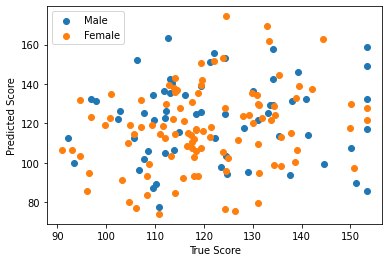

In [122]:
correlation = eval_metric(model(X_val).flatten(), y_val).detach().numpy()
pred_val = model(X_val).flatten()

val_loss = torch.sqrt(criterion(pred_val, y_val))

print('Validation Loss: {}; Pearson correlation: {}'.format(val_loss.item(), np.round(correlation, 2)))

x_m = y_val[gender_val==1]
y_m = pred_val[gender_val==1].detach().numpy()

plt.scatter(x_m, y_m, label="Male")

x_f = y_val[gender_val==0]
y_f = pred_val[gender_val==0].detach().numpy()

plt.scatter(x_f, y_f, label="Female")

print(eval_metric(pred_val[gender_val==1], y_val[gender_val==1]), eval_metric(pred_val[gender_val==0], y_val[gender_val==0]))

print(calculate_regression_measures(y_val, pred_val.detach().numpy(), gender_val))


plt.title("")
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.legend()

(array([2., 5., 1., 3., 3., 7., 3., 2., 3., 2., 7., 4., 5., 4., 2., 6., 4.,
        3., 3., 2., 9., 1., 1., 0., 0., 4., 0., 0., 2., 1.]),
 array([ 93.41    ,  95.40834 ,  97.40667 ,  99.40501 , 101.403336,
        103.40167 , 105.4     , 107.39834 , 109.39667 , 111.395004,
        113.39333 , 115.39167 , 117.39    , 119.388336, 121.386665,
        123.385   , 125.38334 , 127.38167 , 129.38    , 131.37834 ,
        133.37666 , 135.375   , 137.37334 , 139.37167 , 141.37    ,
        143.36833 , 145.36667 , 147.365   , 149.36333 , 151.36166 ,
        153.36    ], dtype=float32),
 <BarContainer object of 30 artists>)

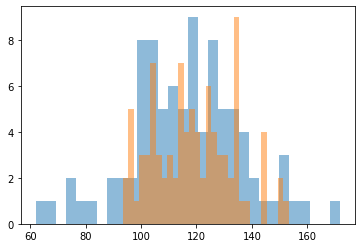

In [37]:
plt.hist(y_f,bins= 30 ,alpha= 0.5)
plt.hist(x_f, bins= 30 ,alpha= 0.5)

tensor(-1.6071, grad_fn=<RsubBackward1>)
Test Loss: 2.32363876714939; Pearson correlation - -0.029999999329447746
MSE: male; tensor(422.7225, grad_fn=<MseLossBackward0>)
MSE: female; 435.46024
tensor(0.2205, grad_fn=<SqueezeBackward0>) tensor(0.2373, grad_fn=<SqueezeBackward0>)
  subgroup  independence  separation  sufficiency
0     Male      1.051169     1.04639     1.000328


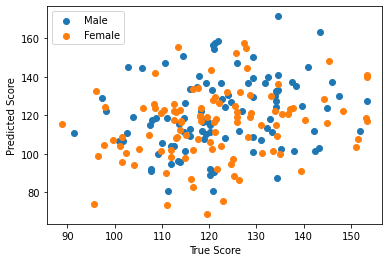

In [121]:
pred_test = model(X_test).flatten()
test_loss = criterion(preds, y_test)
correlation = eval_metric(preds, y_test).detach().numpy()

print(r2_loss(preds, y_test))

print('Test Loss: {}; Pearson correlation - {}'.format(test_loss.item()/len(pred_test), np.round(correlation, 2)))

x = y_test[gender_test==1].numpy()
y = pred_test[gender_test==1].detach().numpy()

print("MSE: male;", criterion(y_test[gender_test==1],pred_test[gender_test==1] ))

plt.scatter(x, y, label="Male")

x = y_test[gender_test==0].numpy()
y = pred_test[gender_test==0].detach().numpy()


print("MSE: female;", ( np.mean((x - y)**2)))

print(
    eval_metric(pred_test[gender_test==1], y_test[gender_test==1]),
  eval_metric(pred_test[gender_test==0], y_test[gender_test==0])
     )
print(calculate_regression_measures(y_test, pred_test.detach().numpy(), gender_test))


plt.scatter(x, y, label="Female")

plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.legend()

In [117]:
1/0.9

1.1111111111111112

In [41]:
## Fairness Check 

from sklearn.linear_model import LogisticRegression

def calculate_regression_measures(y, y_hat, protected, privileged):

    unique_protected = np.unique(protected)
    unique_unprivileged = unique_protected[unique_protected != privileged]

    data = pd.DataFrame(columns=['subgroup', 'independence', 'separation', 'sufficiency'])

    
    for unprivileged in unique_unprivileged:
        # filter elements
        
        array_elements = np.isin(protected, [privileged, unprivileged])

        y_u = ((y[array_elements] - y[array_elements].mean()) / y[array_elements].std()).reshape(-1, 1)
        s_u = ((y_hat[array_elements] - y_hat[array_elements].mean()) / y_hat[array_elements].std()).reshape(-1, 1)

        a = np.where(protected[array_elements] == privileged, 1, 0)

        p_s = LogisticRegression()
        p_ys = LogisticRegression()
        p_y = LogisticRegression()
        
        p_s.fit(s_u, a)
        p_y.fit(y_u, a)
        p_ys.fit(np.c_[y_u, s_u], a)

        pred_p_s = p_s.predict_proba(s_u.reshape(-1, 1))[:, 1]
        pred_p_y = p_y.predict_proba(y_u.reshape(-1, 1))[:, 1]
        pred_p_ys = p_ys.predict_proba(np.c_[y_u, s_u])[:, 1]

        n = len(a)

        r_ind = ((n - a.sum()) / a.sum()) * (pred_p_s / (1 - pred_p_s)).mean()
        r_sep = ((pred_p_ys / (1 - pred_p_ys) * (1 - pred_p_y) / pred_p_y)).mean()
        r_suf = ((pred_p_ys / (1 - pred_p_ys)) * ((1 - pred_p_s) / pred_p_s)).mean()

        to_append = pd.DataFrame({'subgroup': [unprivileged],
                                  'independence': [r_ind],
                                  'separation': [r_sep],
                                  'sufficiency': [r_suf]})

        data = pd.concat([data, to_append])

    # append the scale
    to_append = pd.DataFrame({'subgroup': [privileged],
                              'independence': [1],
                              'separation': [1],
                              'sufficiency': [1]})
    ## TODO: this should be uncommented but adds blanks to the plots
    # data = pd.concat([data, to_append]) 

    data.index = data.subgroup
    data = data.iloc[:, 1:]
    return data


In [75]:
data = pd.DataFrame(columns=['subgroup', 'independence', 'separation', 'sufficiency'])


y = y_test
y_hat = preds.detach().cpu().numpy()

array_elements = (gender_test).nonzero()

y_u = ((y[array_elements] - y[array_elements].mean()) / y[array_elements].std()).reshape(-1, 1)
s_u = ((y_hat[array_elements] - y_hat[array_elements].mean()) / y_hat[array_elements].std()).reshape(-1, 1)

# a = np.where(protected[array_elements] == privileged, 1, 0)
a = np.where(gender_test== "M", 1, 0)

p_s = LogisticRegression()
p_ys = LogisticRegression()
p_y = LogisticRegression()

p_s.fit(s_u, a)
p_y.fit(y_u, a)
p_ys.fit(np.c_[y_u, s_u], a)

pred_p_s = p_s.predict_proba(s_u.reshape(-1, 1))[:, 1]
pred_p_y = p_y.predict_proba(y_u.reshape(-1, 1))[:, 1]
pred_p_ys = p_ys.predict_proba(np.c_[y_u, s_u])[:, 1]

n = len(a)

r_ind = ((n - a.sum()) / a.sum()) * (pred_p_s / (1 - pred_p_s)).mean()
r_sep = ((pred_p_ys / (1 - pred_p_ys) * (1 - pred_p_y) / pred_p_y)).mean()
r_suf = ((pred_p_ys / (1 - pred_p_ys)) * ((1 - pred_p_s) / pred_p_s)).mean()

to_append = pd.DataFrame({'subgroup': "F",
                          'independence': [r_ind],
                          'separation': [r_sep],
                          'sufficiency': [r_suf]})

data = pd.concat([data, to_append])

In [76]:
data

,subgroup,independence,separation,sufficiency
0,F,1.081215,1.055357,1.038829
